# Детекция аномалий на временных рядах

Данный ноутбук демонстрирует применение статистических методов для обнаружения аномалий во временных рядах.

## Основные этапы:

1. Загрузка и предобработка временных рядов
2. Приведение данных к единой гранулярности и обработка пропусков
3. Применение преобразований (нормализация, сглаживание)
4. Детекция аномалий с использованием авторегрессионной модели
5. Визуализация результатов


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = 16, 5
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.format"] = "pdf"
sns.set_style("darkgrid")

Для удобства я оберну все шаги детектора аномалий в отдельные функции. В конце они будут объединены в пайплайн и применены к разным рядам.

Для интерактивных графиков расскоментируйте использование `plots_plotly` и закомментируйте `plots_matplotlib`.

## Загрузка данных

Загружаем временной ряд из CSV-файла.

### Формат хранения рядов:

- `timestamp` (int64): Unix Timestamp в миллисекундах
- `value_0` (float64): значения временного ряда


In [2]:
import pandas as pd


raw_time_series = pd.read_csv("time_series/time_series_1.csv")
raw_time_series.head()

timestamp  value_0
0  1769787300000   7312.0
1  1769787600000   7242.6
2  1769787900000   7121.0
3  1769788200000   6990.2
4  1769788500000   6807.8

## Предобработка временного ряда

### Проверка гранулярности и пропусков

Преобразуем временные метки в формат datetime и анализируем интервалы между последовательными точками для выявления пропусков в данных.

In [3]:
pd.to_datetime(raw_time_series["timestamp"], unit="ms").diff()[1:].value_counts()

timestamp
0 days 00:05:00    4012
0 days 00:10:00       4
0 days 00:15:00       2
0 days 00:20:00       1
Name: count, dtype: int64

### Восстановление равномерной гранулярности

Видим, что очновная частота (гранулярность) - 5 мин., но есть интервалы в 10, 15 и 20 мин. (пропуски в данных). Математические модели требуют временной ряд с равномерной гранулярностью. Восстанавливаем пропущенные значения с помощью ресемплинга и интерполяции.

In [4]:
def get_granularity(time_series: pd.DataFrame):
    diffs = time_series.index.to_series().diff().dropna()
    non_zero_diffs = diffs[diffs > pd.Timedelta(0)]

    if non_zero_diffs.empty:
        granularity = "5min"
    else:
        granularity = non_zero_diffs.value_counts().index[0]
    return granularity


def preprocess_time_series(raw_time_series: pd.DataFrame) -> pd.DataFrame:
    time_series = raw_time_series.dropna(how="all")
    time_series["timestamp"] = pd.to_datetime(time_series["timestamp"], unit="ms")
    time_series = time_series.set_index("timestamp", drop=True)
    granularity = get_granularity(time_series)
    resampled = time_series.resample(granularity).mean().interpolate()
    return resampled


time_series = preprocess_time_series(raw_time_series)
time_series.head()

value_0
timestamp                   
2026-01-30 15:35:00   7312.0
2026-01-30 15:40:00   7242.6
2026-01-30 15:45:00   7121.0
2026-01-30 15:50:00   6990.2
2026-01-30 15:55:00   6807.8

### Визуализация временного ряда

Интерактивный график plotly позволяет детально исследовать данные: приближать участки, перемещаться по временной оси.

<Axes: title={'center': 'Time Series'}, xlabel='Time', ylabel='Value'>

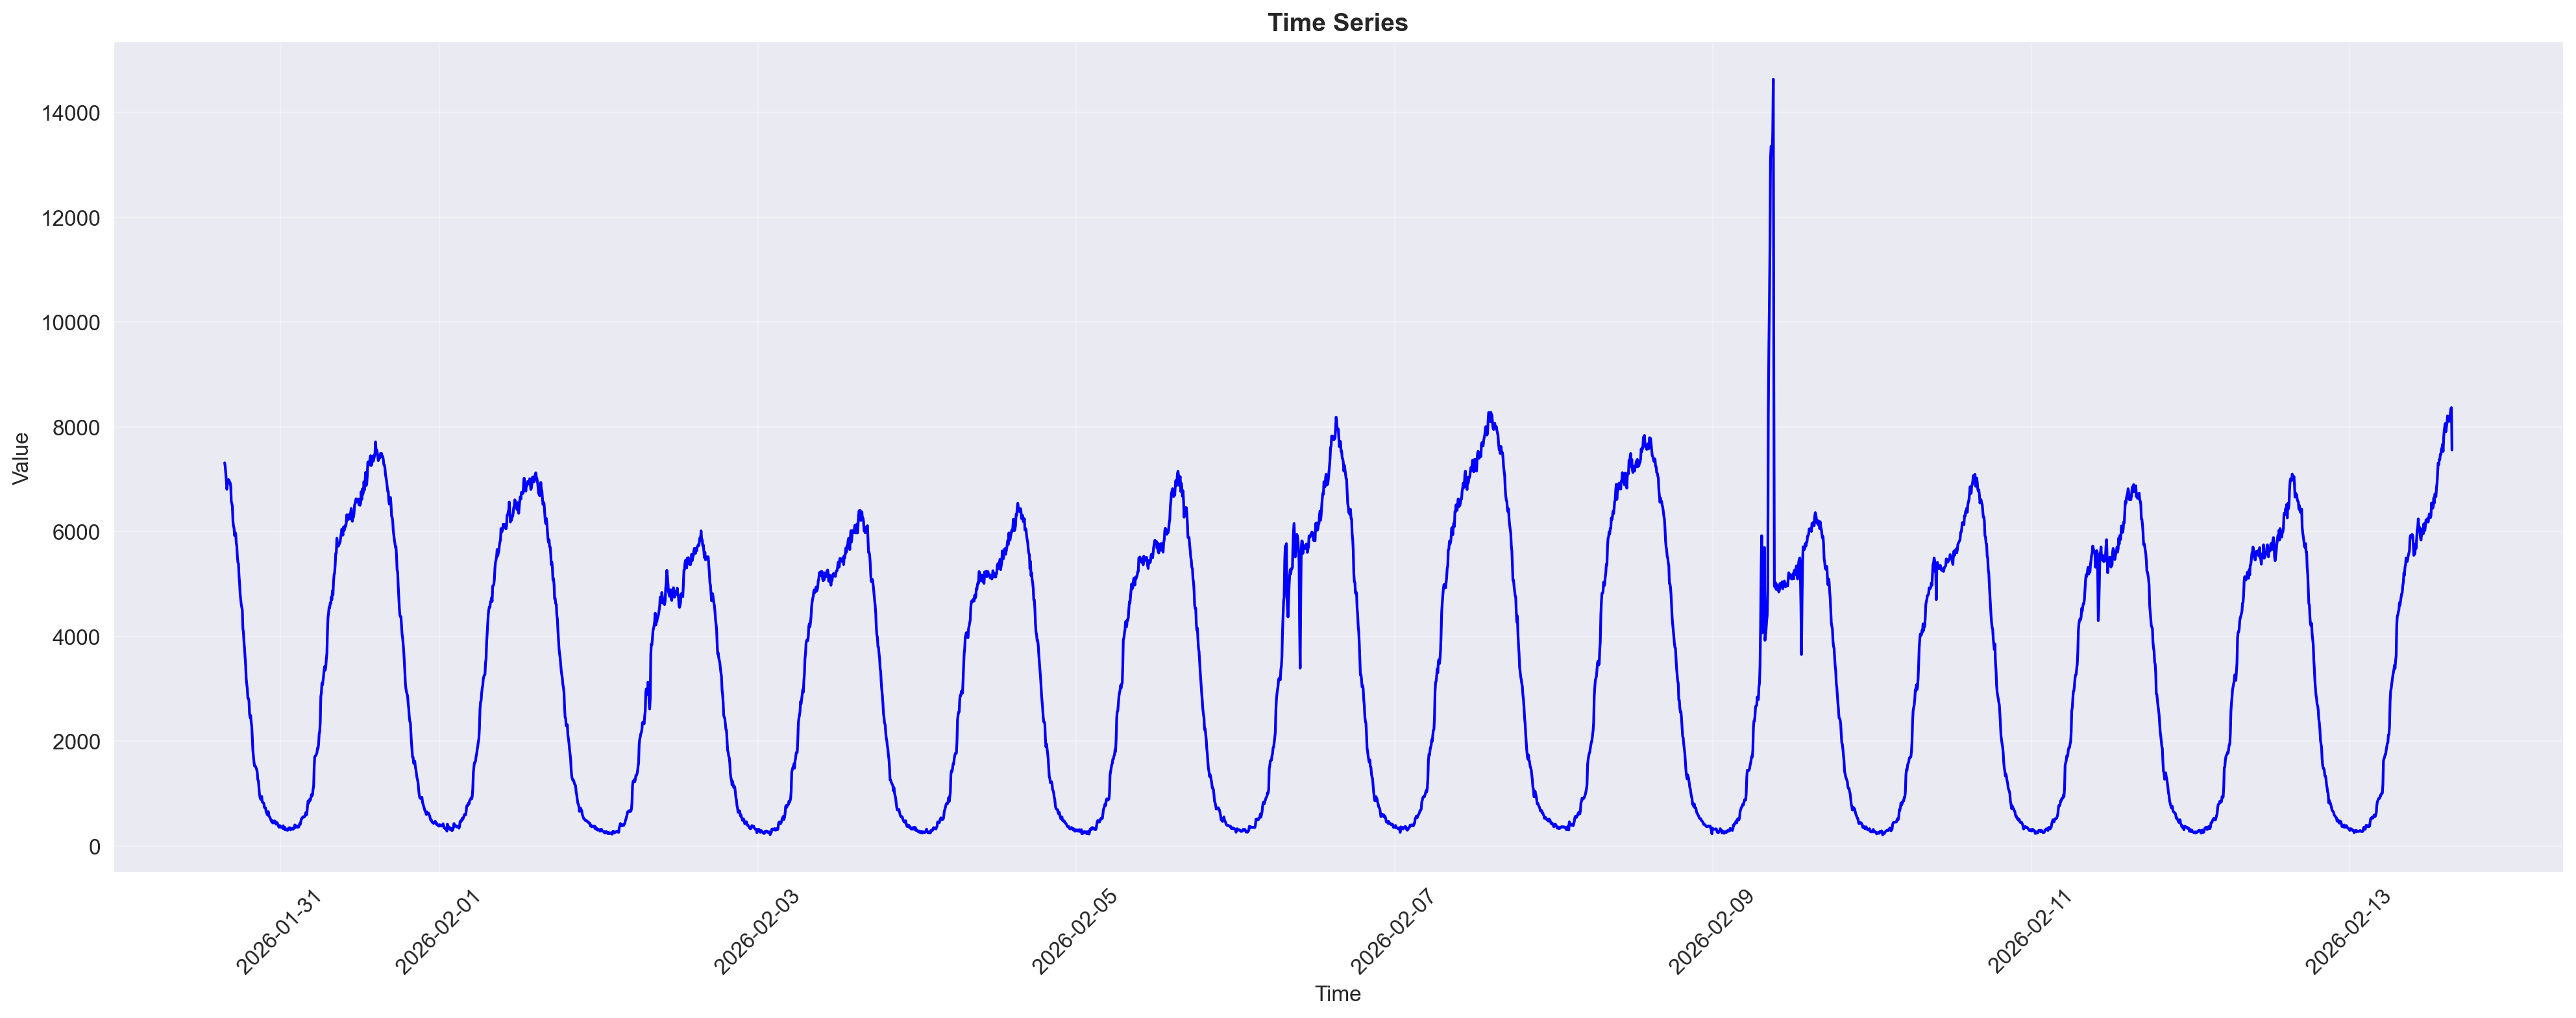

In [ ]:
import plots_matplotlib
import plots_plotly


# plots_plotly.plot_time_series(time_series)
plots_matplotlib.plot_time_series(time_series)

## Преобразования временного ряда

\[Опционально\] Применяем стандартные преобразования для подготовки данных к анализу:

- **Resample** - изменение гранулярности временного ряда (агрегация/интерполяция)
- **Normalization** - стандартизация значений (вычитание среднего и деление на стандартное отклонение)
- **Smoothing** - сглаживание с помощью скользящего среднего для уменьшения шума

<Axes: title={'center': 'Time Series'}, xlabel='Time', ylabel='Value'>

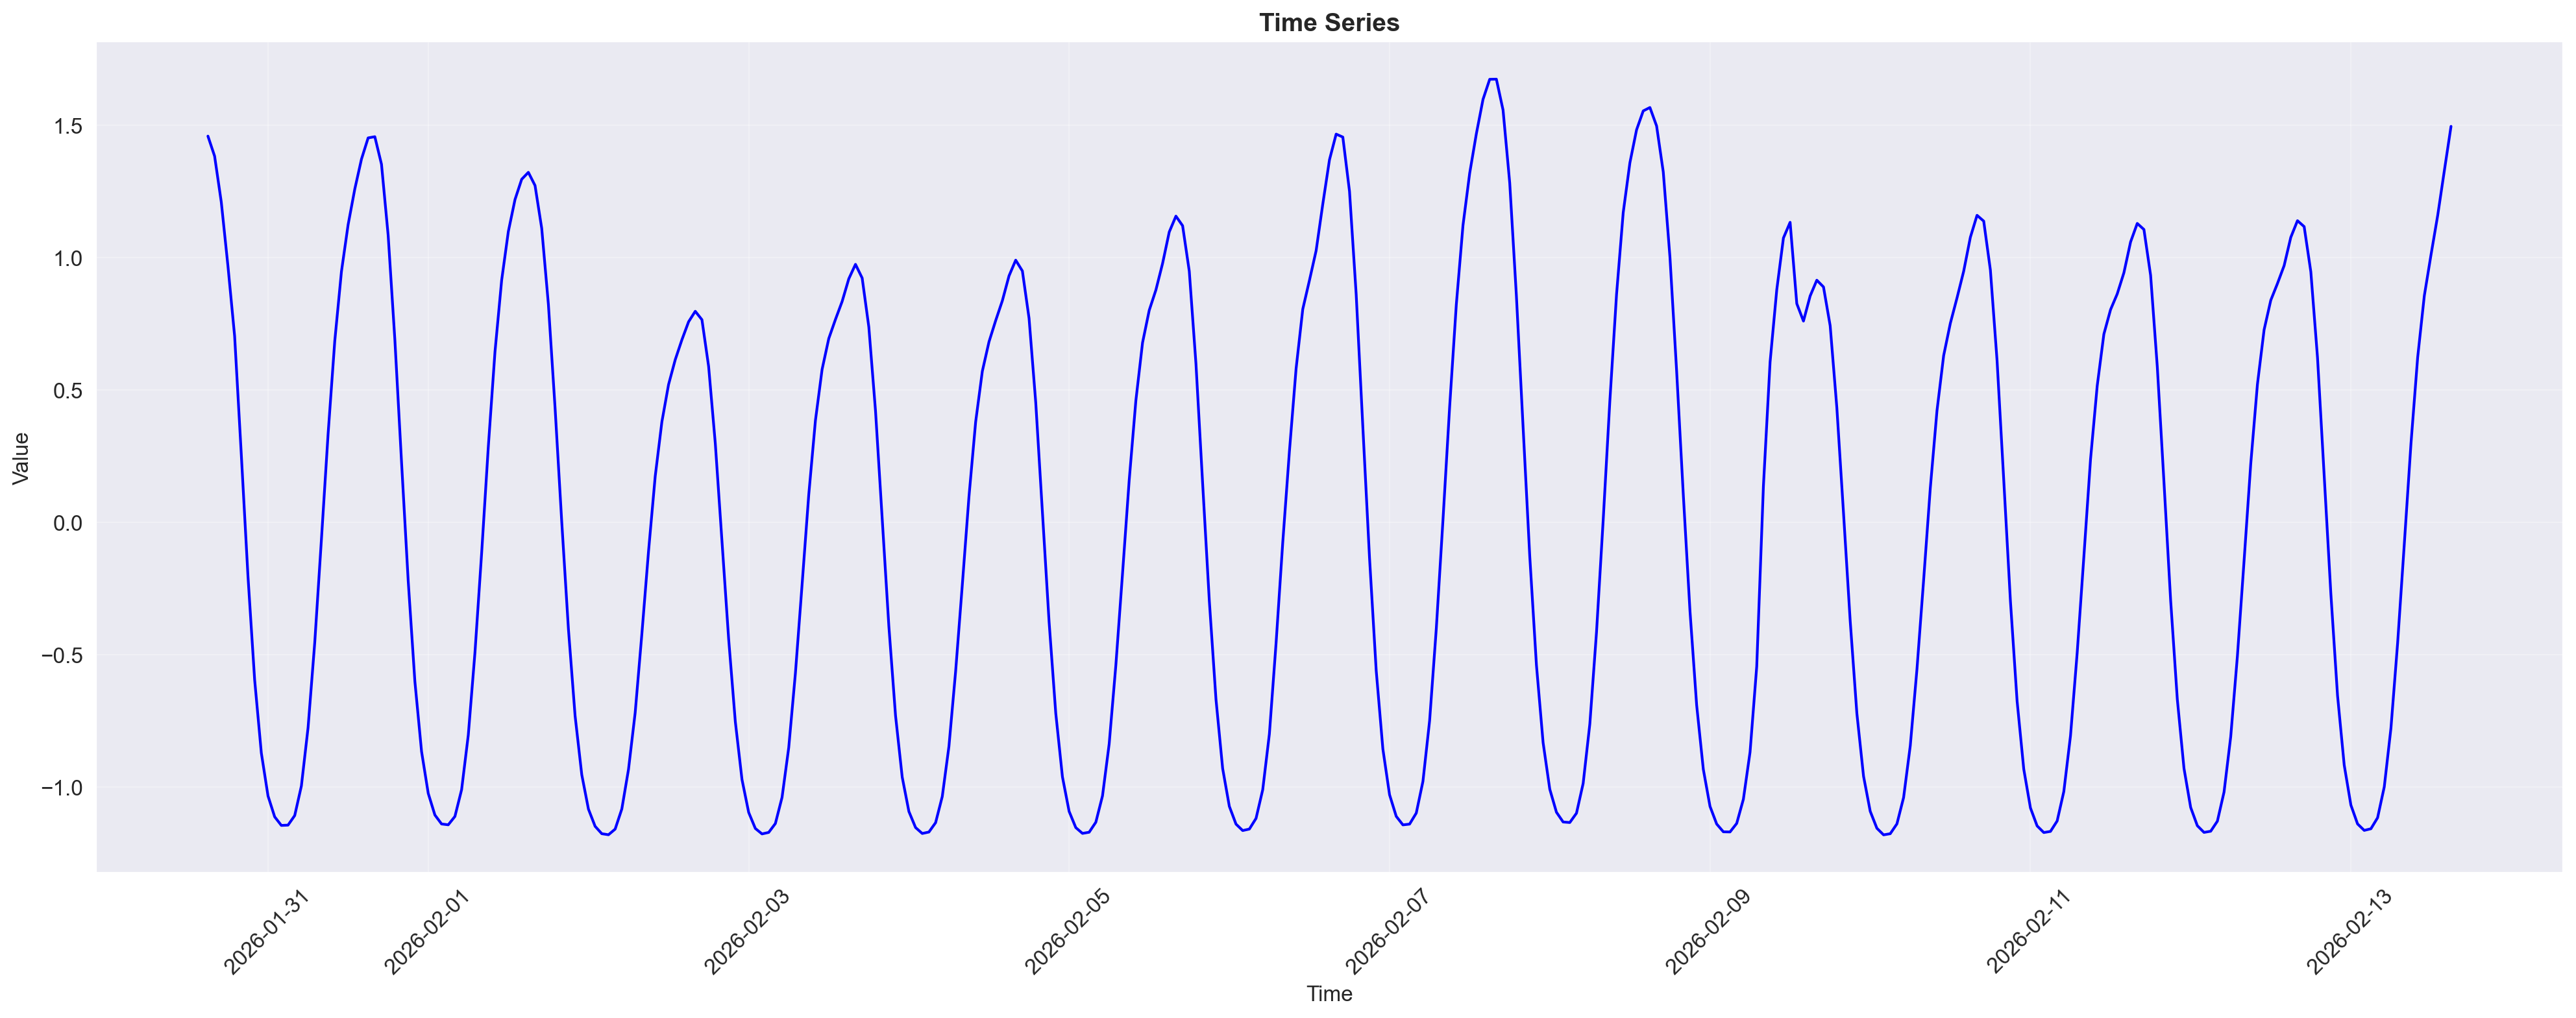

In [6]:
def resample(time_series: pd.DataFrame, granularity: str = "5min") -> pd.DataFrame:
    resampled = time_series.resample(granularity).mean().interpolate()
    return resampled


def normalize(time_series: pd.DataFrame) -> pd.DataFrame:
    return (time_series - time_series.mean()) / (time_series.std() + 1e-7)


def smooth(time_series: pd.DataFrame, n_steps: int = 1) -> pd.DataFrame:
    return time_series.rolling(window=n_steps, min_periods=1).mean()


resampled = resample(time_series, "1h")
normalized = normalize(resampled)
smoothed = smooth(normalized, 5)

# plots_plotly.plot_time_series(smoothed, title="Transformed Time Series")
plots_matplotlib.plot_time_series(smoothed, title="Transformed Time Series")

## Детекция Аномалий

Теперь рассмотрим как применять детекторы аномалий. Для этого используем z_scores


### Основная идея
Строим прогнозирование временного ряда в каждой точке по предыдущим значениям и анализируем отклонения (остатки)

### Прогнозирующая модель
$\hat{y}_t$ — прогноз модели в точке $t$ на основе предыдущих $p$ значений

### Расчёт остатков
$$r_t = y_t - \hat{y}_t$$

### Z-score для детекции аномалий
$$z_t = \frac{|r_t|}{\sigma_r}$$

где $\sigma_r$ — стандартное отклонение остатков. Для устойчивости его можно оценить через MAD (абсолютное медианное отклонение)

### Статистический тест
- **Гипотеза**: остатки распределены нормально $r_t \sim \mathcal{N}(0, \sigma_r^2)$
- **Правило**: точка аномальна, если $z_t > \text{threshold}$ (по умолчанию 3)
- **Интерпретация**: значение выходит за пределы 3-сигма интервала (99.7% вероятности для нормального распределения)

### Доверительные границы
$$[\hat{y}_t - \text{threshold} \cdot \sigma_r, \quad \hat{y}_t + \text{threshold} \cdot \sigma_r]$$
***


Модель детекции аномалий должна возвращать структурированный результат, содержащий:

- **is_anomaly** - булевый массив, указывающий аномальные точки
- **anomaly_scores** - массив z-score значений для каждой точки
- **expected_values** - прогнозные значения модели
- **expected_bounds** - доверительные границы (нижняя и верхняя)

### Применение авторегрессионного детектора

Авторегрессионная модель (AR) прогнозирует текущее значение как линейную комбинацию предыдущих значений. Параметр `order` определяет количество учитываемых предыдущих точек.


In [7]:
from dataclasses import dataclass
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.tsatools import detrend


@dataclass
class DetectionResult:
    is_anomaly: np.array
    anomaly_scores: np.array
    expected_values: np.array
    expected_bounds: np.array


def autoreg_detector(
    time_series: pd.DataFrame, threshold: float = 3.0, order: int = 20
) -> DetectionResult:
    time_series_values = time_series["value_0"]
    model = AutoReg(time_series_values, lags=order)
    model_fit = model.fit()
    prediction = np.concatenate((time_series_values[:order], model_fit.fittedvalues))

    residuals = time_series_values - prediction
    residuals_std = (
        np.sqrt(np.mean(residuals**2)) + 1e-8
    )  # assume that E(residuals) = 0

    z_scores = np.abs(residuals / residuals_std)
    expected_bounds = np.column_stack(
        (
            prediction - residuals_std * threshold,
            prediction + residuals_std * threshold,
        )
    )

    return DetectionResult(
        is_anomaly=(z_scores > threshold),
        anomaly_scores=z_scores,
        expected_values=prediction,
        expected_bounds=expected_bounds,
    )

In [8]:
THRESHOLD = 5.0

detection_result = autoreg_detector(time_series, threshold=THRESHOLD)

### Визуализация результатов детекции

Красные точки обозначают обнаруженные аномалии. Синяя область показывает доверительный интервал нормальных значений.


<Axes: title={'center': 'Time Series'}, xlabel='Time', ylabel='Value'>

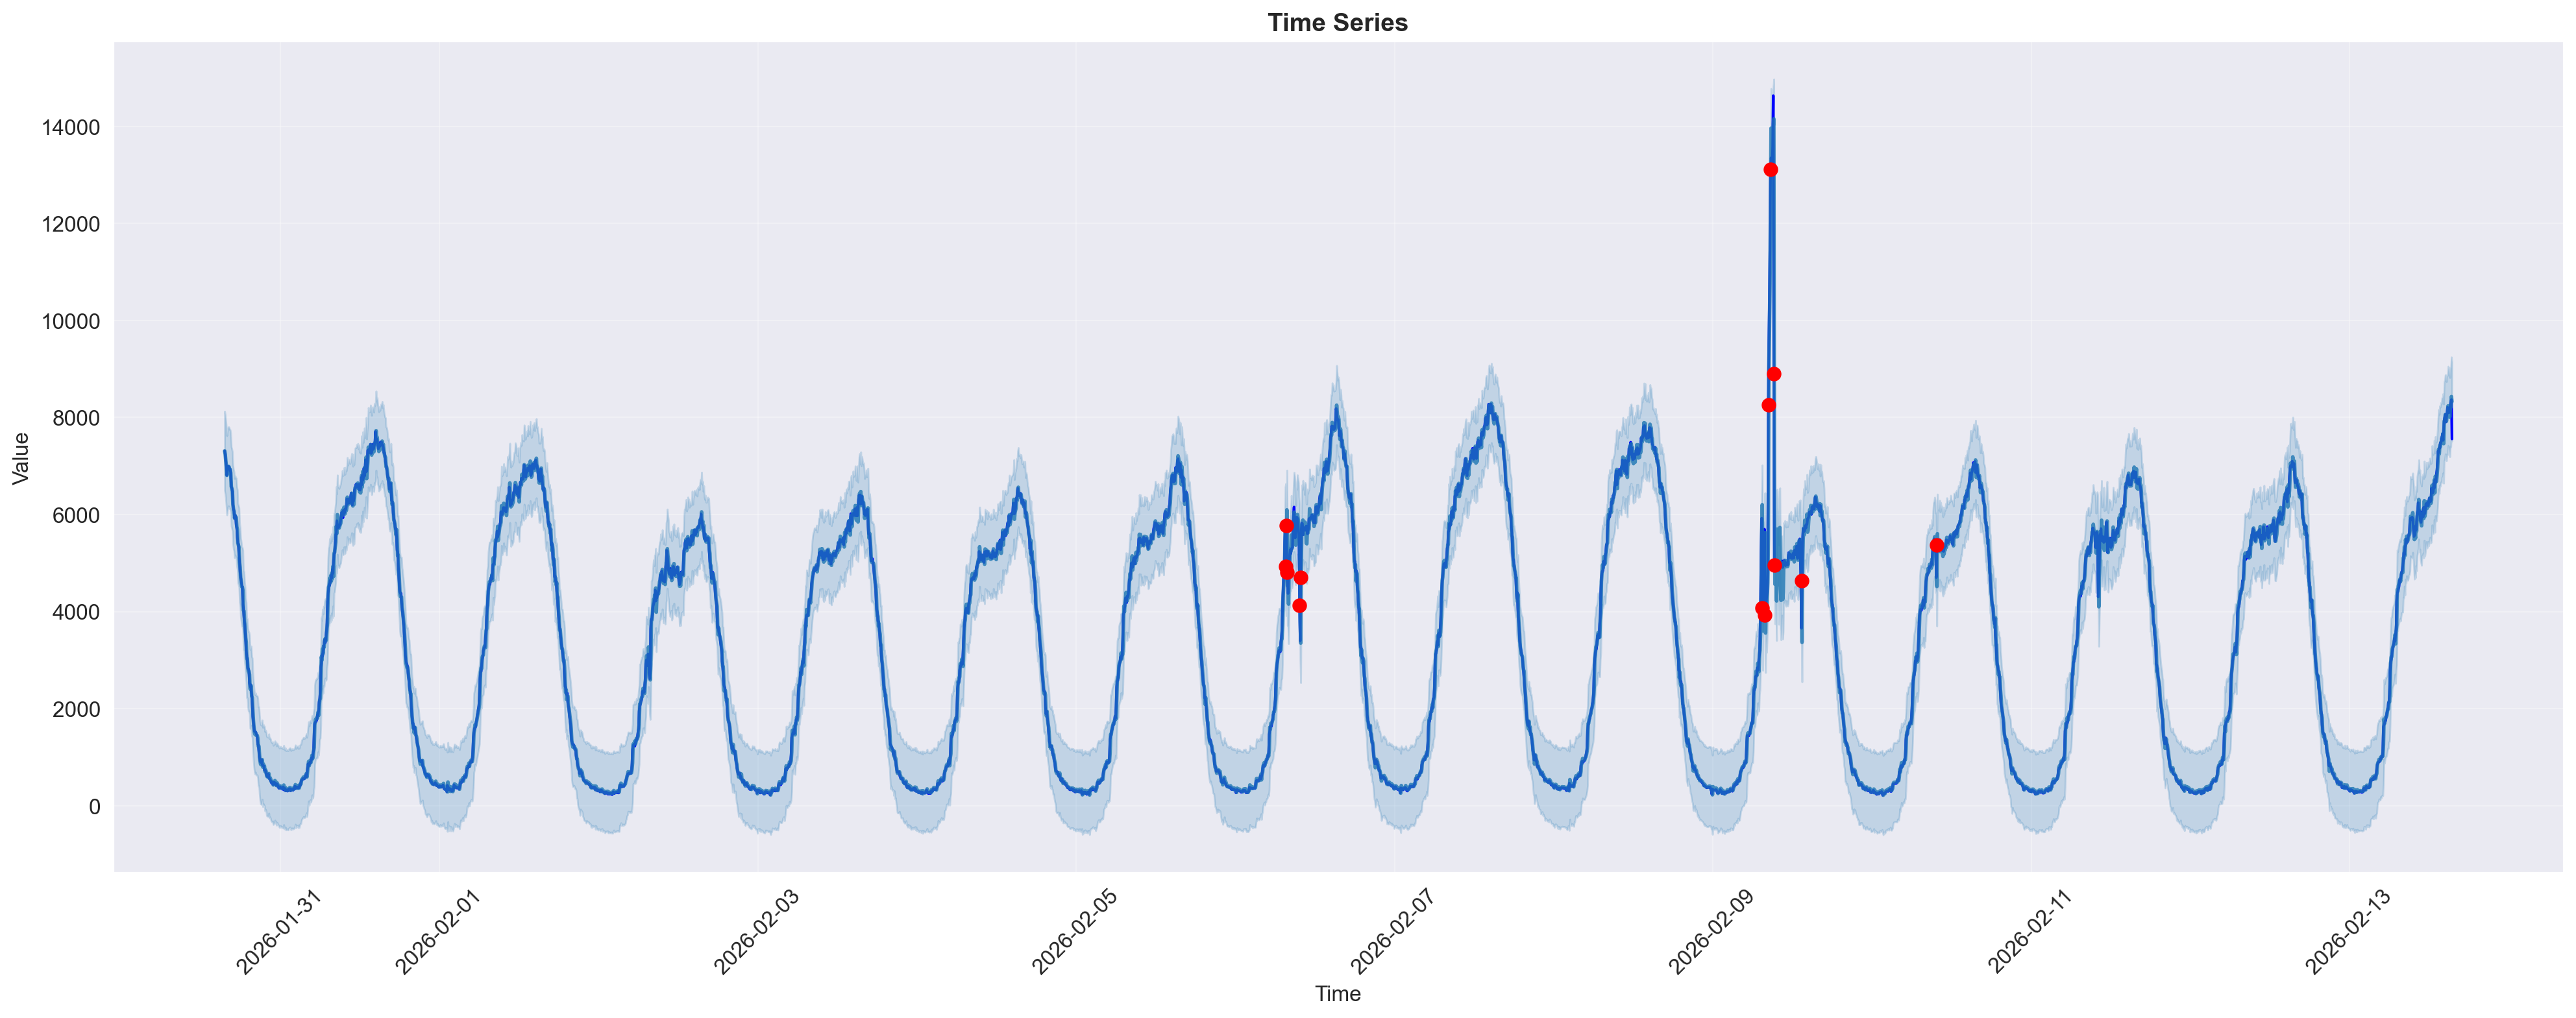

In [9]:
# fig = plots_plotly.plots_plotlyplot_time_series(time_series)
# plots_plotly.add_anomalies(
#     fig,
#     time_series,
#     detection_result.is_anomaly,
#     detection_result.expected_values,
#     detection_result.expected_bounds,
# )


fig = plots_matplotlib.plot_time_series(time_series)
plots_matplotlib.add_anomalies(
    fig,
    time_series,
    detection_result.is_anomaly,
    detection_result.expected_values,
    detection_result.expected_bounds,
)

## Постобработка результатов

### Восстановление исходной гранулярности

Если мы попробуем записать полученные предсказания в таблицу оригинального временного ряда, то у нас ничего не получится. При предобработке мы добавили пропущенные точки для получения равномерной гранулярности. Теперь необходимо интерполировать результаты обратно в формат оригинального временного ряда.

In [10]:
print("Length of detection result:", detection_result.expected_values.shape[0])
print("Length of processed time series:", time_series.shape[0])
print("Length of original time series:", raw_time_series.shape[0])

Length of detection result: 4031
Length of processed time series: 4031
Length of original time series: 4020


In [11]:
def interpolate_detection_result(
    detection_result: DetectionResult,
    original_time_series: pd.DataFrame,
    processed_time_series: pd.DataFrame,
) -> tuple[np.ndarray, np.ndarray]:
    anomaly_scores = np.interp(
        original_time_series.index.astype(int),
        processed_time_series.index.astype(int),
        detection_result.anomaly_scores,
    )

    expected_values = np.interp(
        original_time_series.index.astype(int),
        processed_time_series.index.astype(int),
        detection_result.expected_values,
    )

    expected_bounds = np.column_stack(
        [
            np.interp(
                original_time_series.index.astype(int),
                processed_time_series.index.astype(int),
                detection_result.expected_bounds[:, i],
            )
            for i in range(2)
        ]
    )

    return anomaly_scores, expected_values, expected_bounds


anomaly_scores, expected_values, expected_bounds = interpolate_detection_result(
    detection_result,
    raw_time_series.set_index(pd.to_datetime(raw_time_series["timestamp"], unit="ms")),
    time_series,
)

is_anomaly = anomaly_scores > THRESHOLD

In [12]:
print("Length of detection result:", expected_values.shape[0])
print("Length of processed time series:", time_series.shape[0])
print("Length of original time series:", raw_time_series.shape[0])

Length of detection result: 4020
Length of processed time series: 4031
Length of original time series: 4020


Результаты детекции теперь соответствуют оригинальному временному ряду, который поступил на вход as-is.

## Полный пайплайн детекции аномалий

Объединяем все этапы в единую функцию и применяем к различным временным рядам.

In [13]:
def anomaly_detection_pipeline(time_series_path: str):
    raw_time_series = pd.read_csv(time_series_path)
    time_series = preprocess_time_series(raw_time_series)
    detection_result = autoreg_detector(time_series, threshold=5)

    fig = plots_matplotlib.plot_time_series(time_series)
    plots_matplotlib.add_anomalies(
        fig,
        time_series,
        detection_result.is_anomaly,
        detection_result.expected_values,
        detection_result.expected_bounds,
    )
    plt.show()

    anomaly_scores, expected_values, expected_bounds = interpolate_detection_result(
        detection_result,
        raw_time_series.set_index(
            pd.to_datetime(raw_time_series["timestamp"], unit="ms")
        ),
        time_series,
    )

    is_anomaly = anomaly_scores > THRESHOLD

    return {
        "anomaly_scores": anomaly_scores,
        "expected_values": expected_values,
        "expected_bounds": expected_bounds,
        "is_anomaly": is_anomaly,
    }

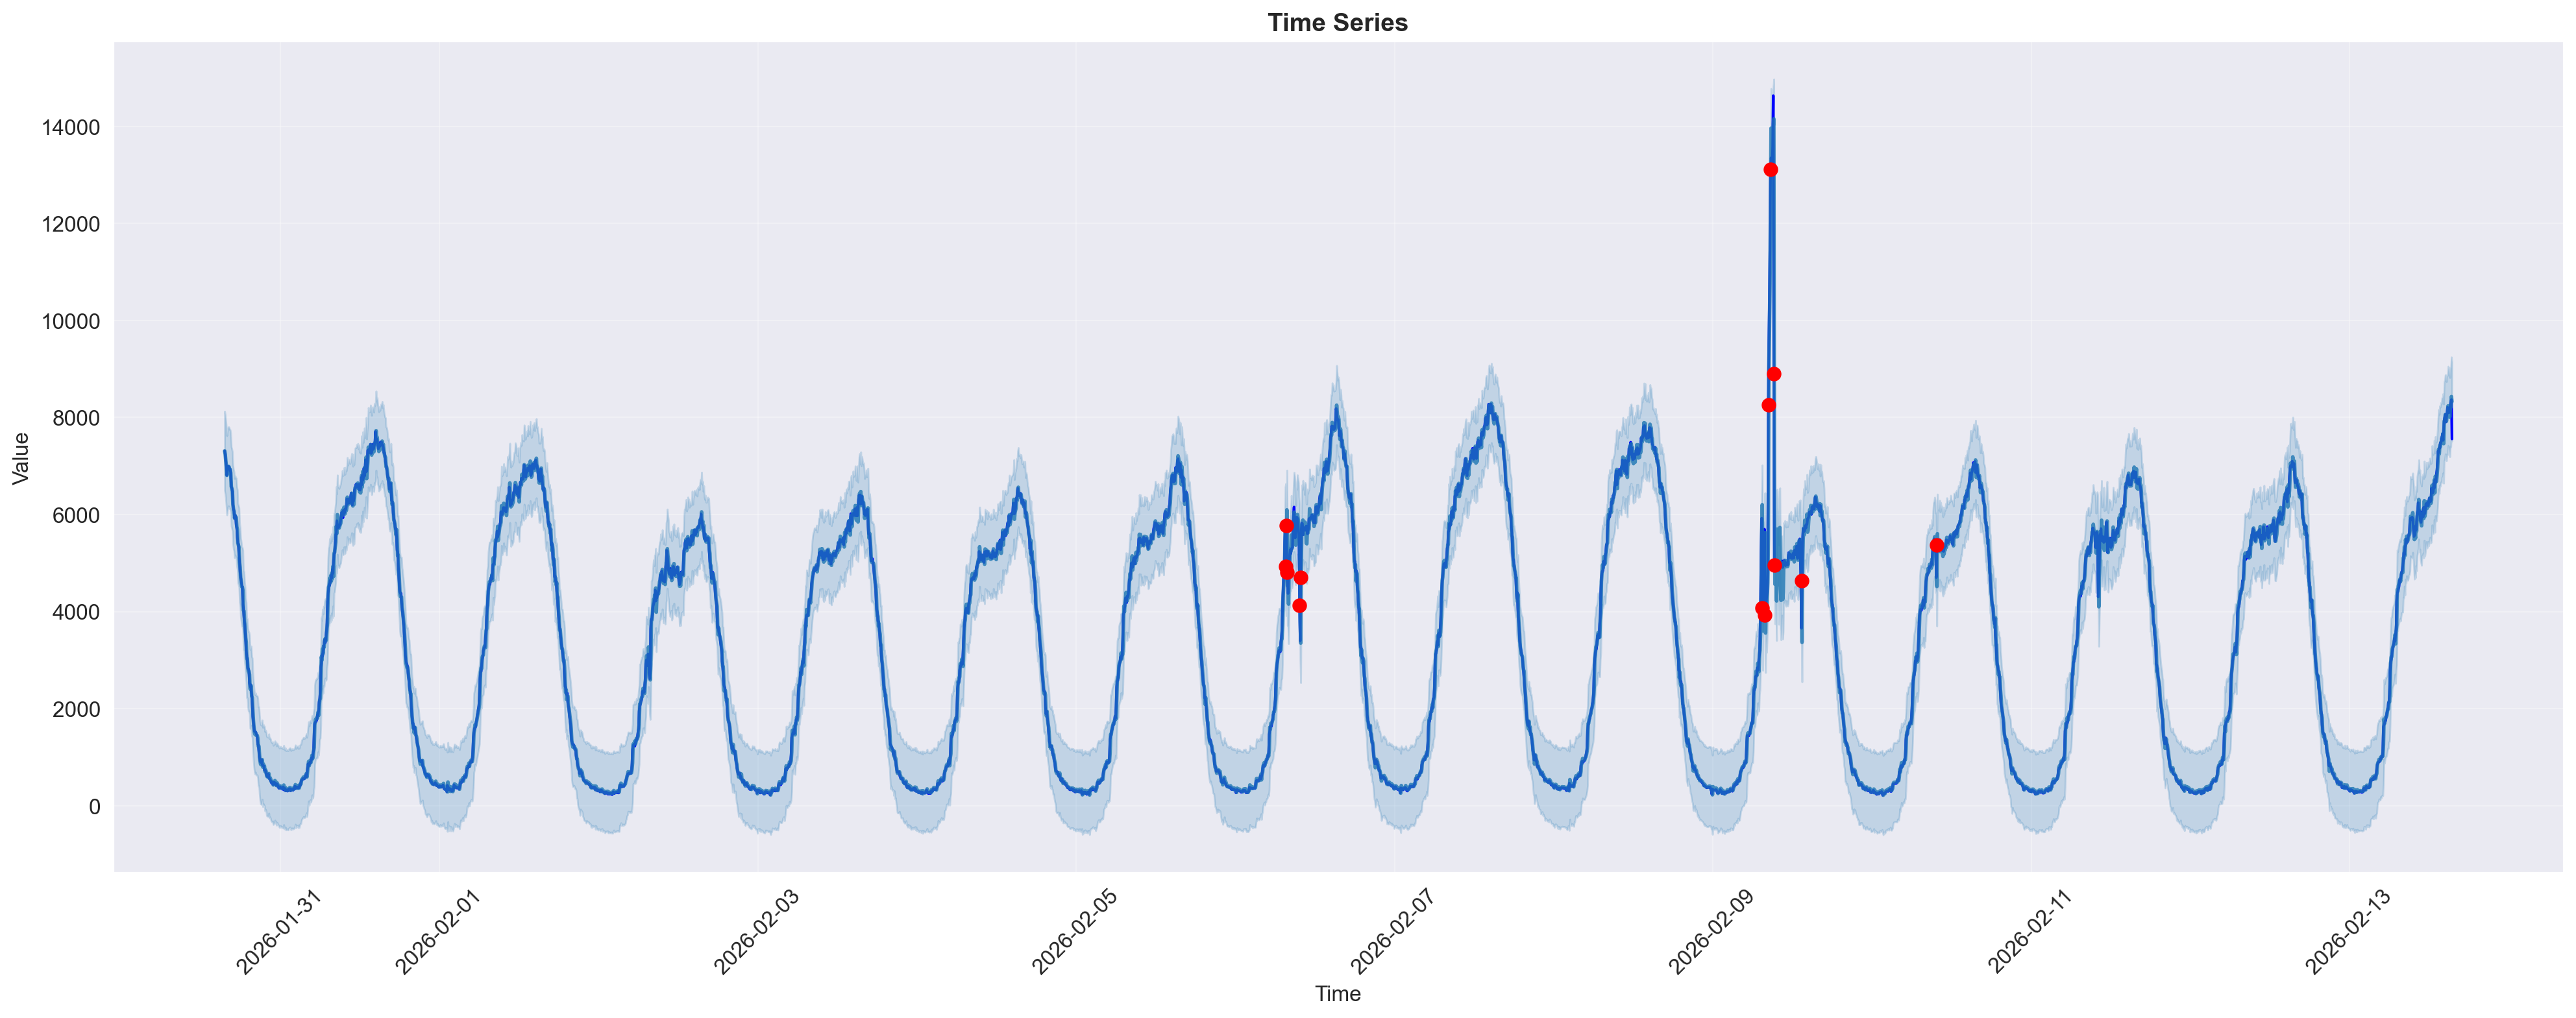

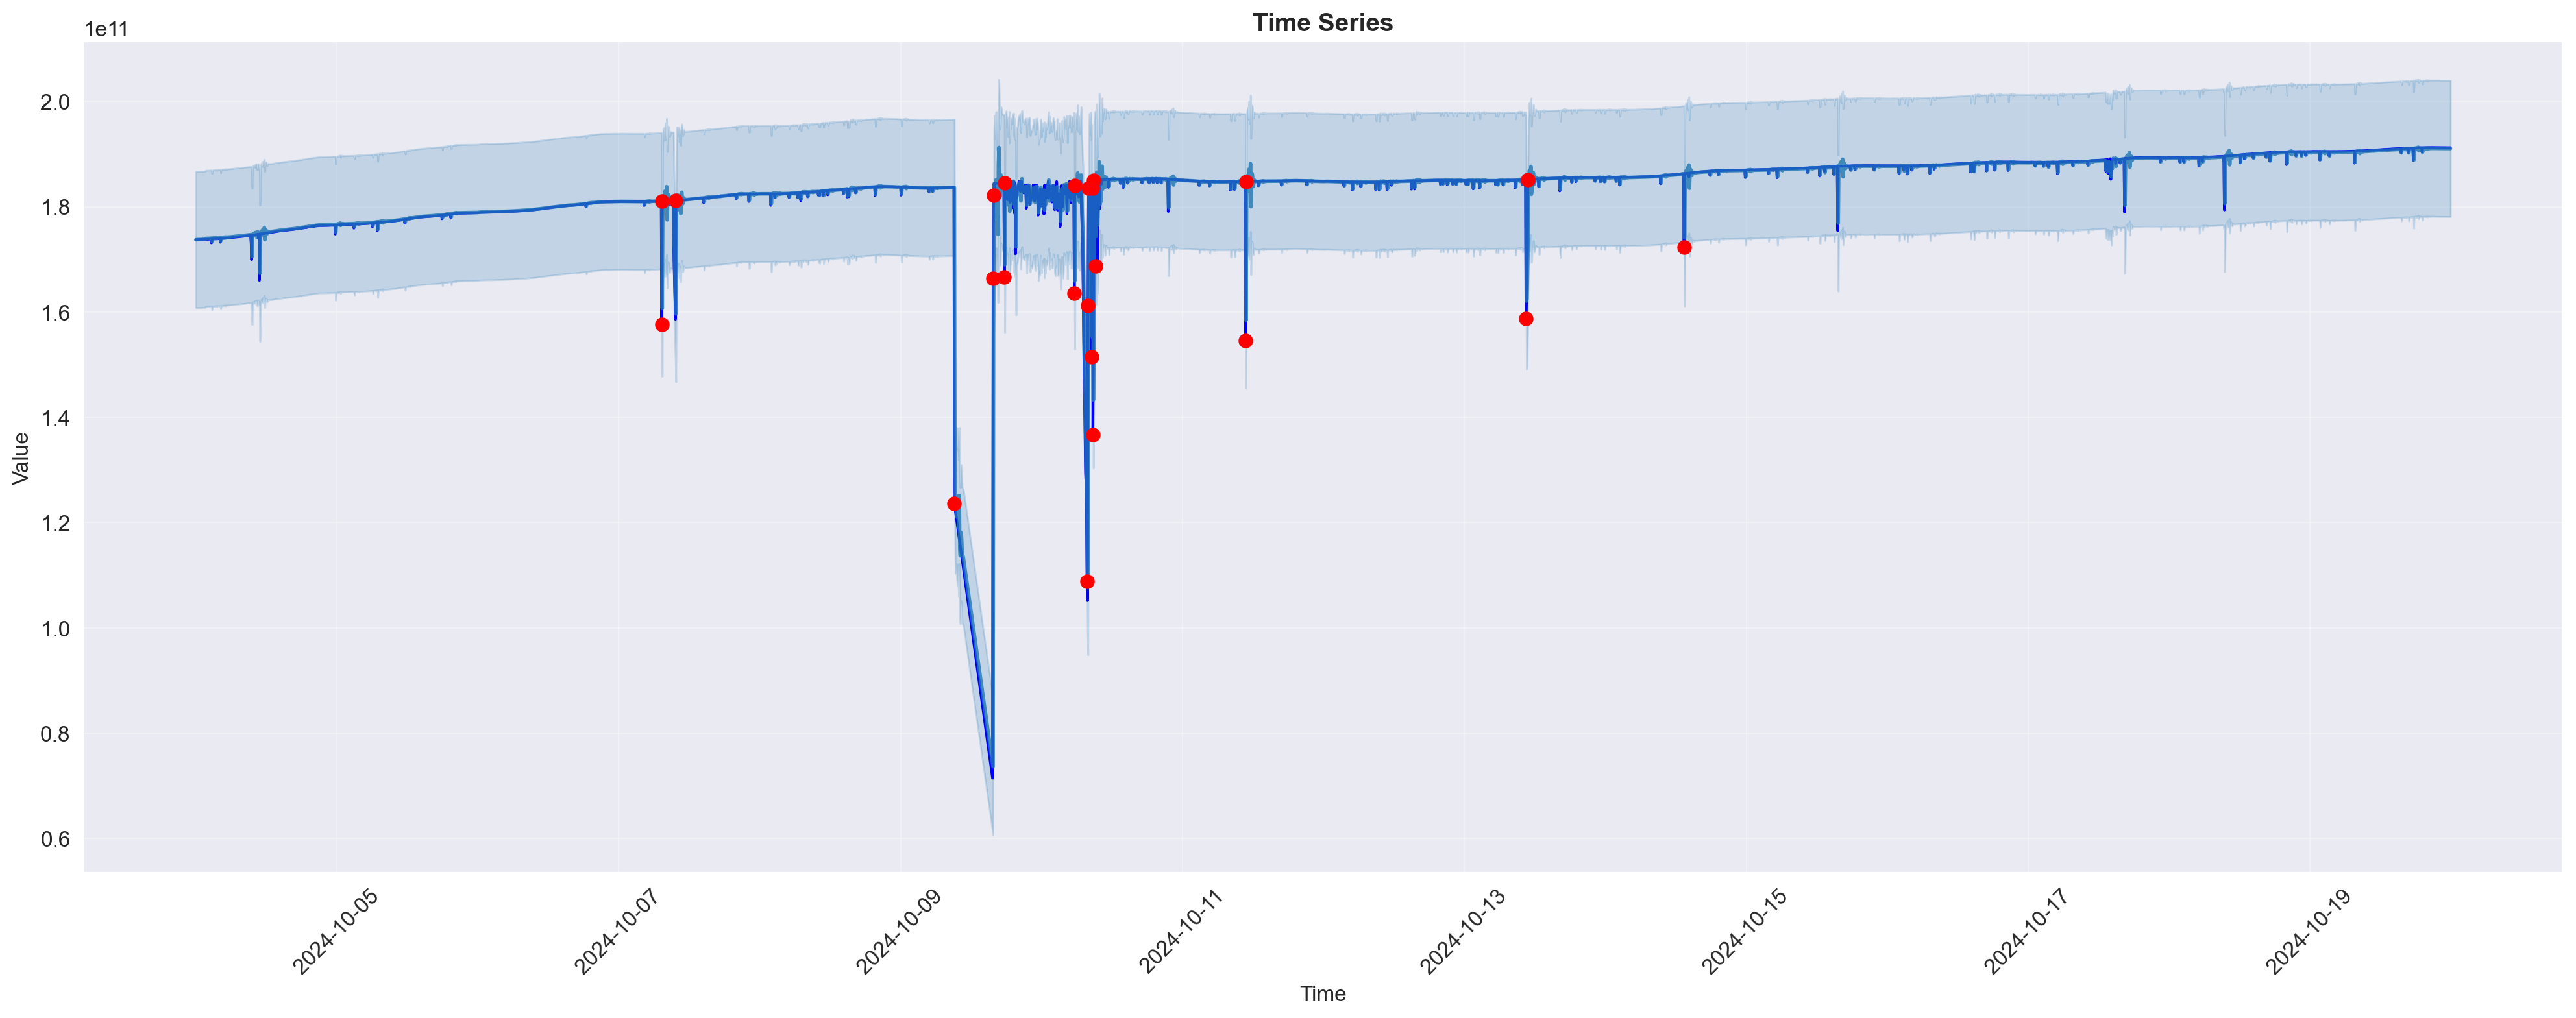

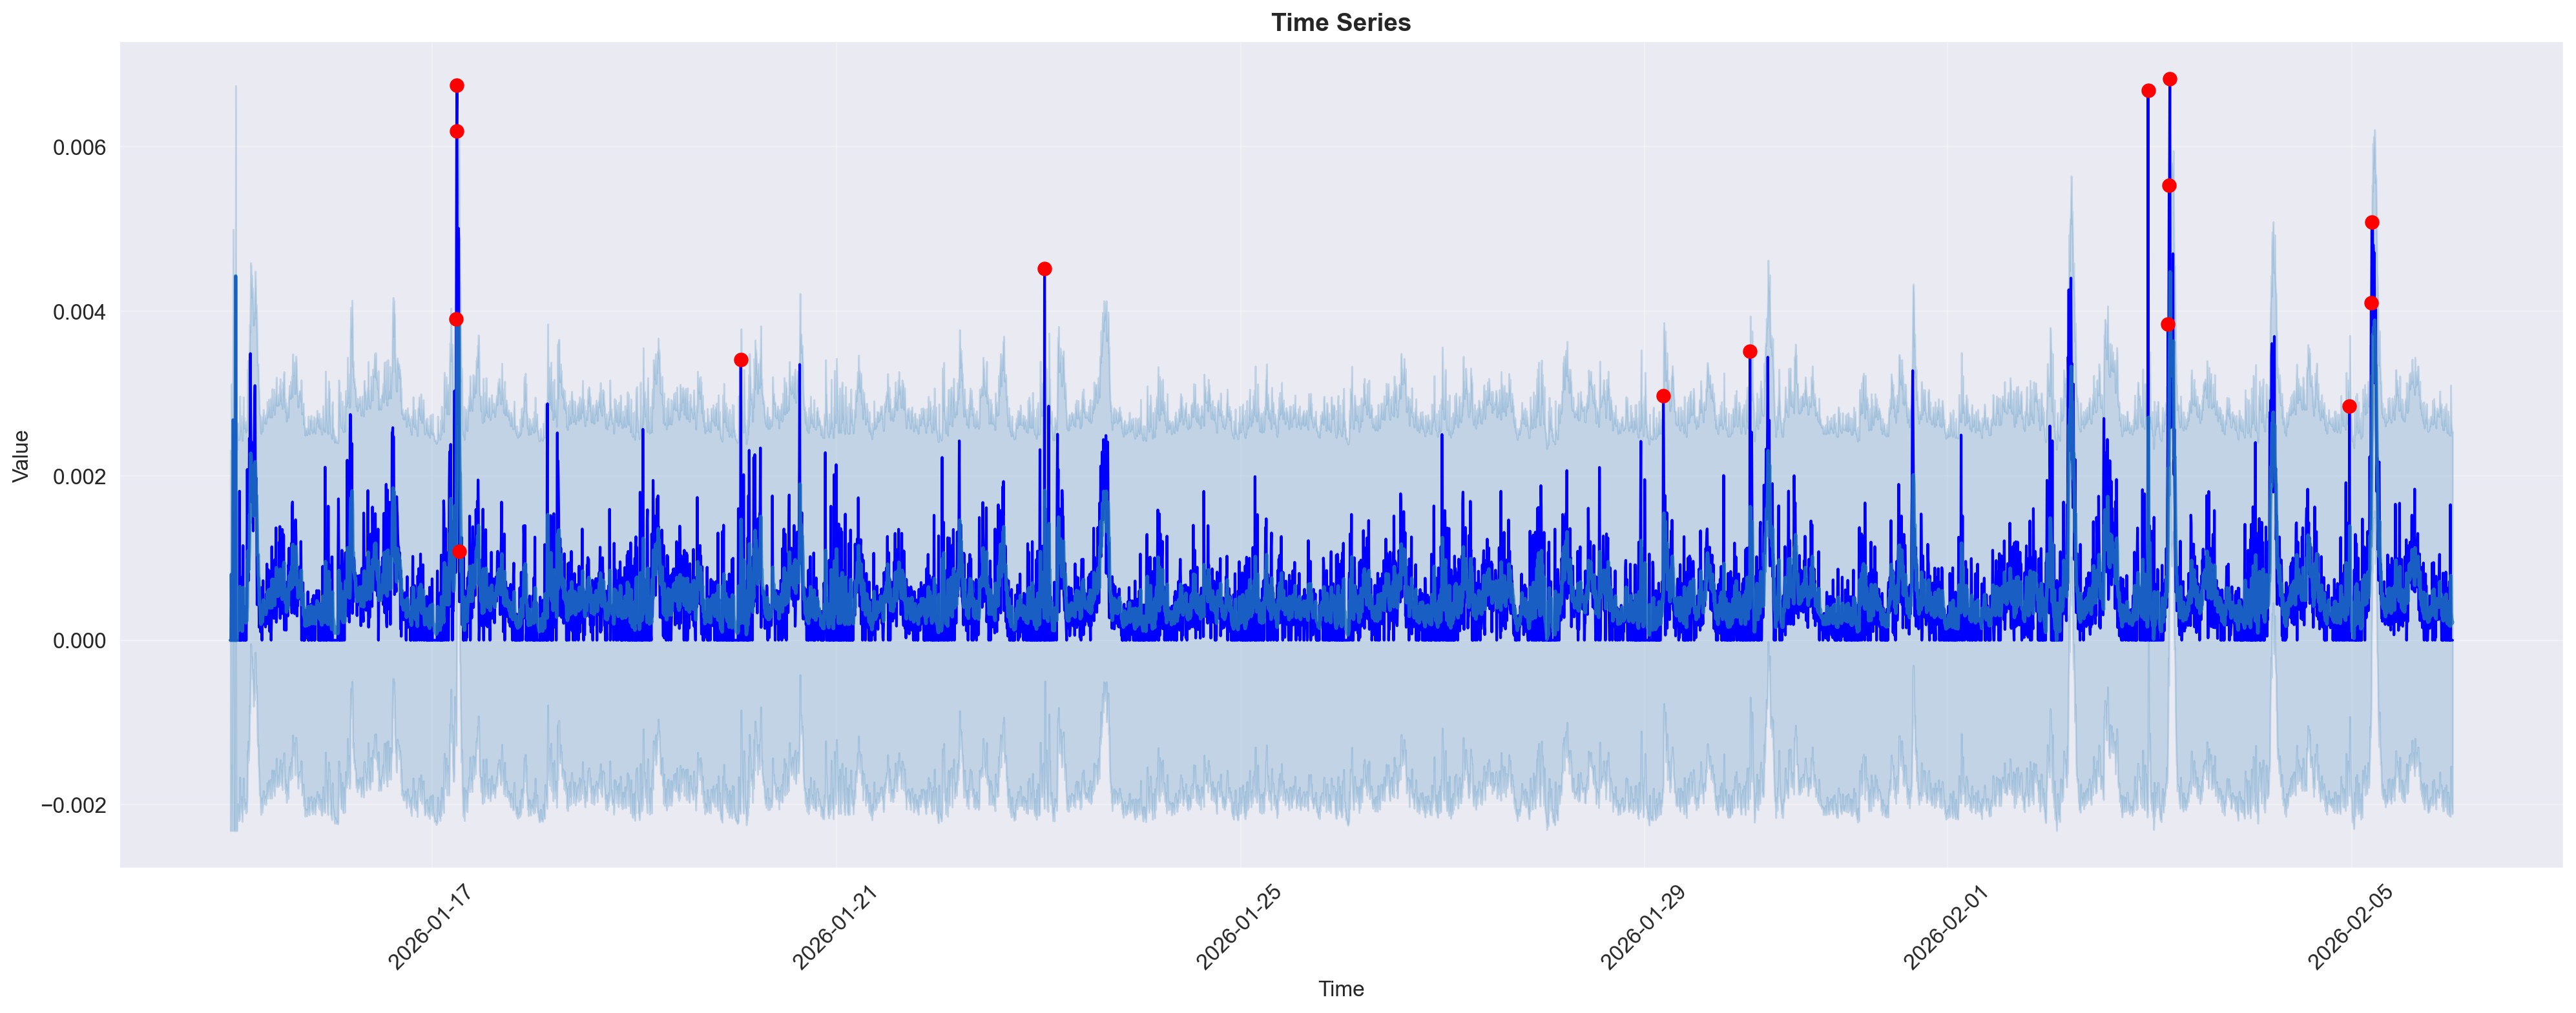

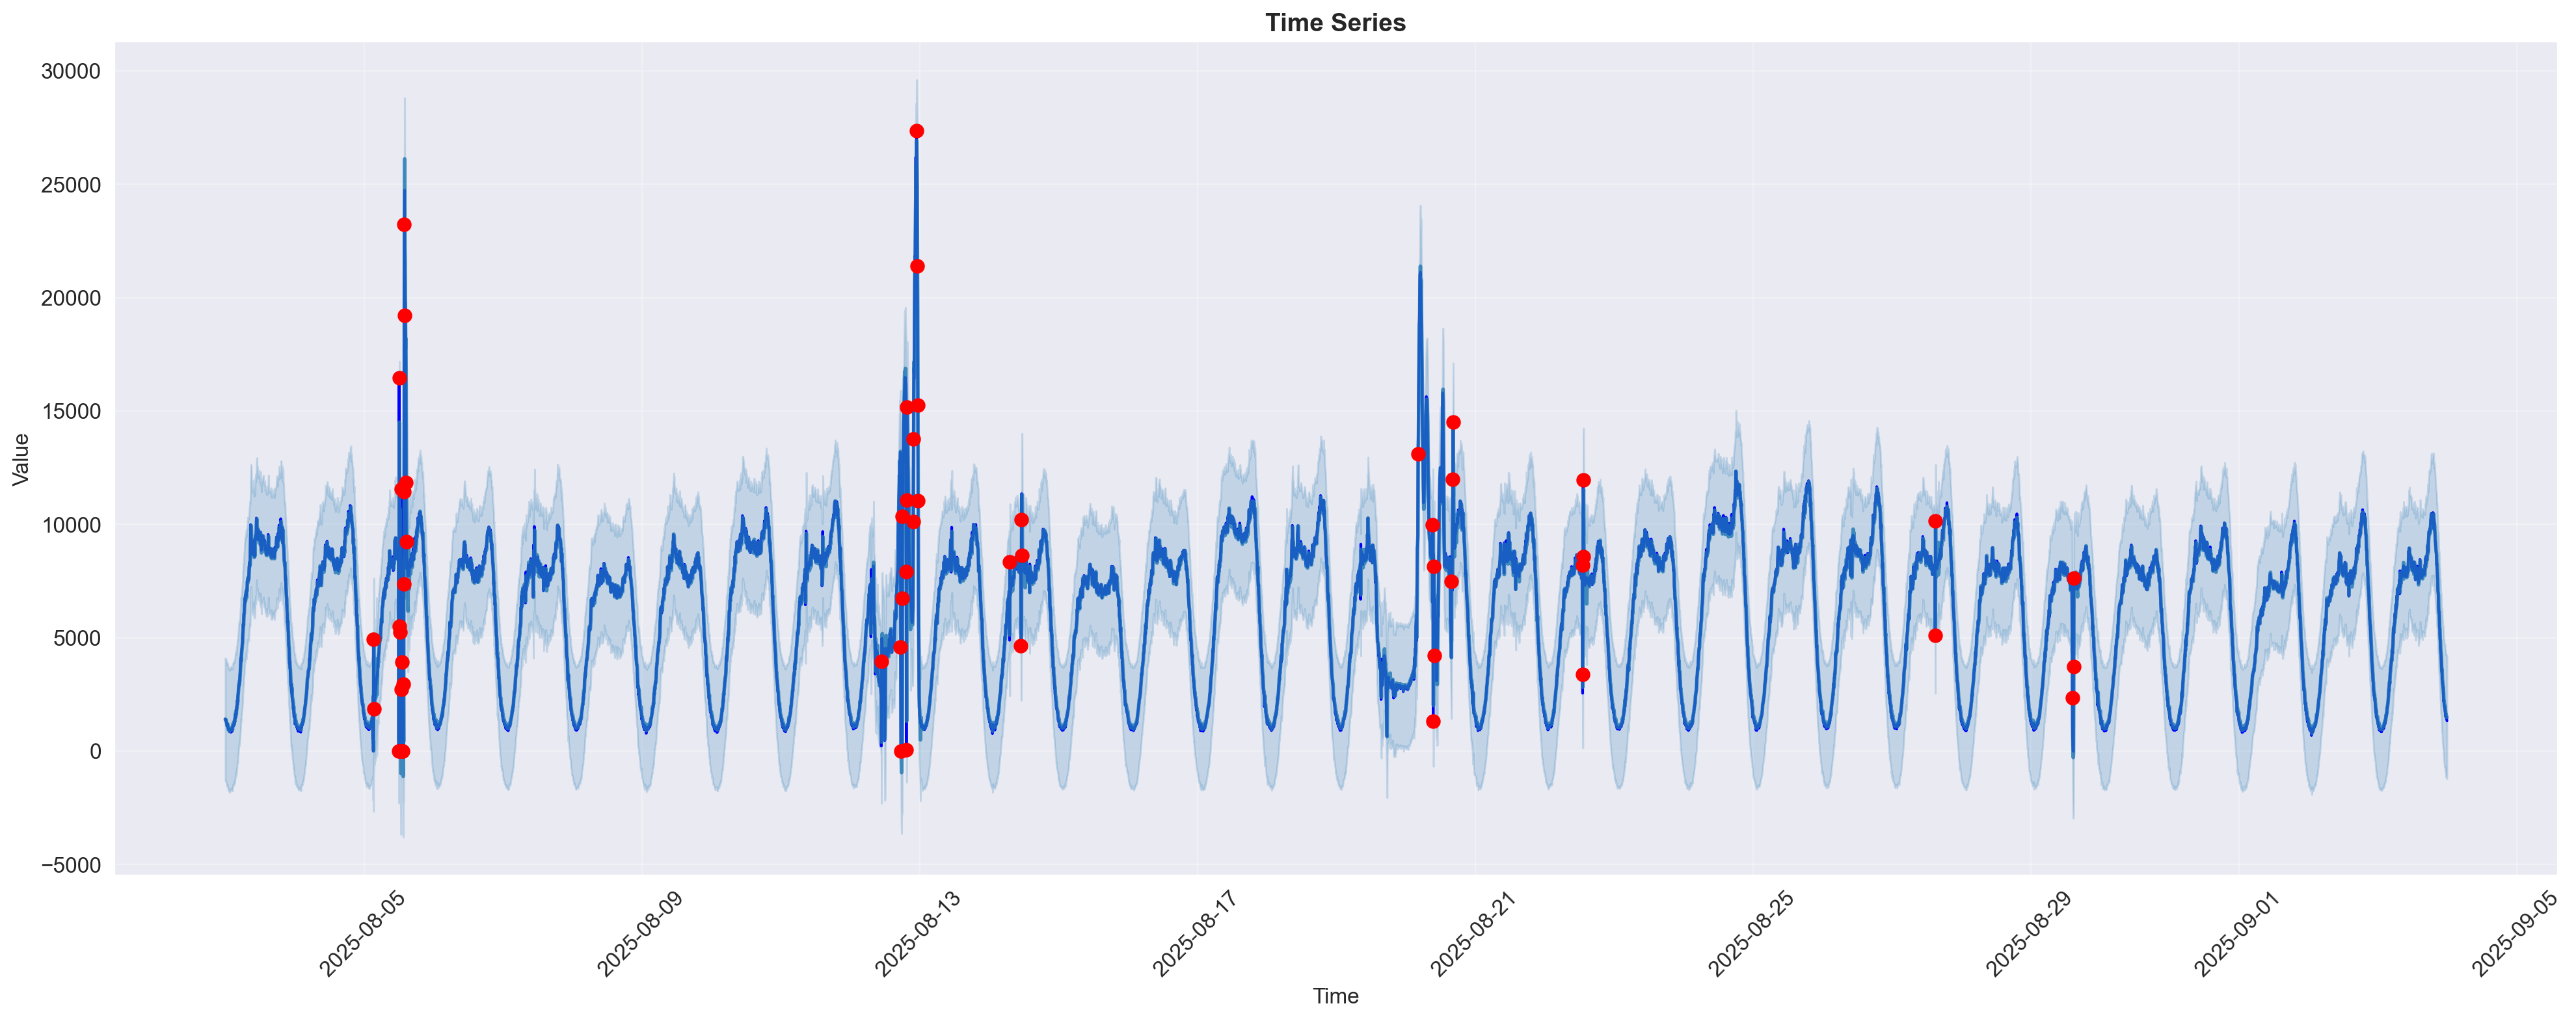

In [14]:
import os

for root, dirs, files in os.walk("time_series"):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            anomaly_detection_pipeline(file_path)

## Дополнительно: сезонный детектор аномалий

Альтернативный метод детекции, учитывающий сезонность данных. Подходит для временных рядов с периодическими паттернами (недельная, дневная сезонность).

### Метод:

1. Удаление тренда из временного ряда
2. Выделение сезонной компоненты через медианное усреднение по периодам
3. Анализ остатков после удаления тренда и сезонности
4. Применение z-score критерия к остаткам

<Axes: title={'center': 'Time Series'}, xlabel='Time', ylabel='Value'>

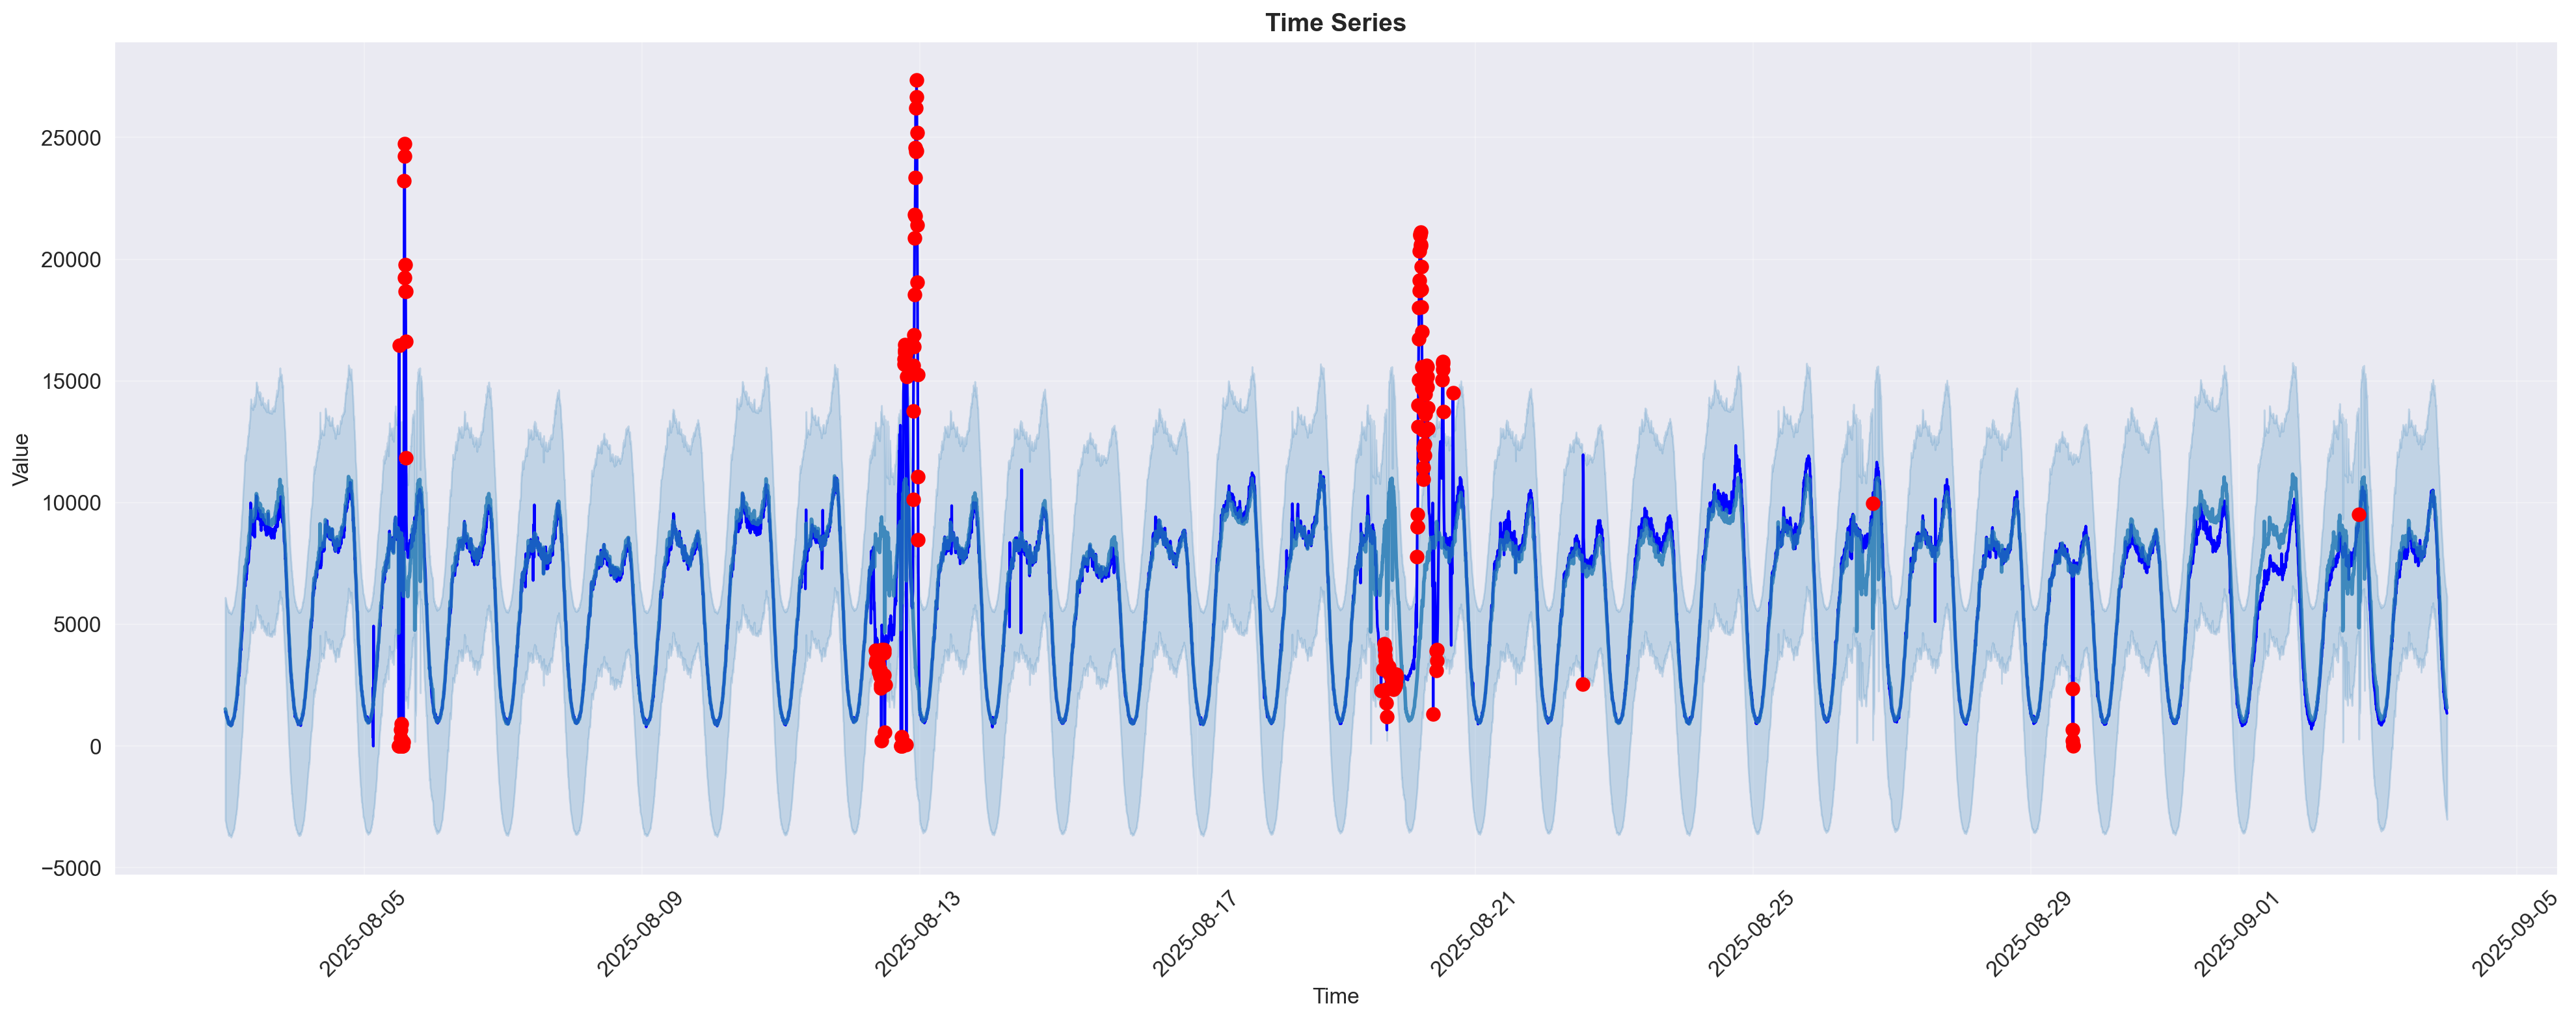

In [ ]:
def seasonal_component(series, period):
    series = np.asarray(series)
    n_periods = len(series) // period
    trimmed = series[: n_periods * period]
    reshaped = trimmed.reshape(-1, period)
    seasonality = np.median(reshaped, axis=0)
    repeated = np.tile(seasonality, n_periods + 1)[: len(series)]
    return repeated


def seasonal_detector(
    time_series: pd.DataFrame, lag: str = "1w", threshold: float = 3.0
) -> DetectionResult:
    time_diff = time_series.index[1] - time_series.index[0]
    lag_timedelta = pd.Timedelta(lag)
    lag_points = int(lag_timedelta / time_diff)

    values = time_series["value_0"].values
    detrended_values = detrend(values, order=1)
    residuals = detrended_values - seasonal_component(detrended_values, lag_points)

    residuals_std = np.sqrt(np.mean(residuals**2))
    z_scores = np.abs(residuals / residuals_std)
    expected_values = values - residuals
    expected_bounds = np.column_stack(
        (
            expected_values - residuals_std * threshold,
            expected_values + residuals_std * threshold,
        )
    )

    return DetectionResult(
        anomaly_scores=z_scores,
        is_anomaly=(z_scores > threshold),
        expected_values=expected_values,
        expected_bounds=expected_bounds,
    )


raw_time_series = pd.read_csv("time_series/time_series_3.csv")
time_series = preprocess_time_series(raw_time_series)
detection_result = seasonal_detector(time_series, threshold=3)

# fig = plots_plotly.plots_plotlyplot_time_series(time_series)
# plots_plotly.add_anomalies(
#     fig,
#     time_series,
#     detection_result.is_anomaly,
#     detection_result.expected_values,
#     detection_result.expected_bounds,
# )

fig = plots_matplotlib.plot_time_series(time_series)
plots_matplotlib.add_anomalies(
    fig,
    time_series,
    detection_result.is_anomaly,
    detection_result.expected_values,
    detection_result.expected_bounds,
)